# Training a food siamese model

imports

In [1]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import time
import copy

In [2]:
ROOT="/kaggle/input/food-dataset/"
# ROOT = "Project Data/"
CONV_NET = "googlenet"
SIZE = (244, 244)
BATCH_SIZE = 64
EMBEDDING_DIM = 64
EPOCHS_COUNT = 30
MARGIN = 1.5

### Creating triplets for a training or validation

In [3]:
torch.manual_seed(40)
torch.cuda.manual_seed_all(40)

In [4]:
def create_triplets(directory, folders):
    triplets = []

    # loop over each food folder. the folder name is the class label
    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))  # get all the images in the folder
        num_files = len(files)

        for i in range(num_files - 1):  # anchors
            for j in range(i + 1, num_files):  # positives
                anchor = (folder, files[i])
                positive = (folder, files[j])

                neg_folder = folder
                while neg_folder == folder:  # get random negative
                    neg_folder = random.choice(folders)
                neg_files = os.listdir(os.path.join(directory, neg_folder))
                neg_file = random.choice(neg_files)
                negative = (neg_folder, neg_file)

                triplets.append((anchor, positive, negative))

    random.shuffle(triplets)
    return triplets


### Get the list of food folders

In [5]:
trainList = os.listdir(ROOT + "Food/Train/")
validationList = os.listdir(ROOT + "Food/Validation/")

### Create Triplets for each set

In [6]:
trainTriplets = create_triplets(ROOT + "Food/Train", trainList)
validationTriplets = create_triplets(ROOT + "Food/Validation", validationList)

In [7]:
print("Number of training triplets :", len(trainTriplets))
print("Number of validation triplets :", len(validationTriplets))

print("\nExamples of triplets:")
for i in range(5):
    print(validationTriplets[i])

Number of training triplets : 42611
Number of validation triplets : 4692

Examples of triplets:
(('spring_rolls', '3383387.jpg'), ('spring_rolls', '3068228.jpg'), ('crab_cakes', '1974639.jpg'))
(('bruschetta', '2386512.jpg'), ('bruschetta', '1842107.jpg'), ('ceviche', '217909.jpg'))
(('crab_cakes', '2318691.jpg'), ('crab_cakes', '1736806.jpg'), ('pho', '2657524.jpg'))
(('bruschetta', '3472240.jpg'), ('bruschetta', '1043336.jpg'), ('crab_cakes', '889170.jpg'))
(('pho', '3559597.jpg'), ('pho', '51112.jpg'), ('ceviche', '183297.jpg'))


In [8]:
train_transforms = transforms.Compose(
    [
        transforms.RandomPerspective(
            distortion_scale=0.2, p=0.5, fill=128
        ),  # augmentation
        transforms.RandomRotation(10),  # augmentation
        transforms.RandomResizedCrop(
            size=SIZE, scale=(0.5, 1.0), ratio=(0.75, 1.33)
        ),  # resizing is essential but cropping is augmentation
        transforms.RandomHorizontalFlip(0.5),  # augmentation
        transforms.ColorJitter(0.3, 0.3, 0.3),  # augmentation
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),  # essential
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize(SIZE),
        transforms.ToTensor(),
    ]
)


In [9]:
def read_and_process_image(
    split, index, size=SIZE, image_transforms=transforms.ToTensor()
):
    path = os.path.join(ROOT, "Food", split, index[0], index[1])
    if not os.path.exists(path):
        print("Error : path " + str(path) + " Doesn't exist")
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, SIZE)
    image = image_transforms(image)
    # normalize the image
    # image = image / 255.0
    return image


### Batch generator for training loop

In [10]:
def get_batch(
    split, triplet_list, batch_size=256, image_transforms=transforms.ToTensor()
):
    batch_steps = len(triplet_list) // batch_size
    for i in range(batch_steps + 1):
        anchor = []
        positive = []
        negative = []

        j = i * batch_size
        while j < (i + 1) * batch_size and j < len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_and_process_image(split, a, image_transforms))
            positive.append(read_and_process_image(split, p, image_transforms))
            negative.append(read_and_process_image(split, n, image_transforms))
            j += 1

        anchor = torch.stack(anchor)
        positive = torch.stack(positive)
        negative = torch.stack(negative)

        yield ([anchor, positive, negative])


### Plot a part of the first training batch

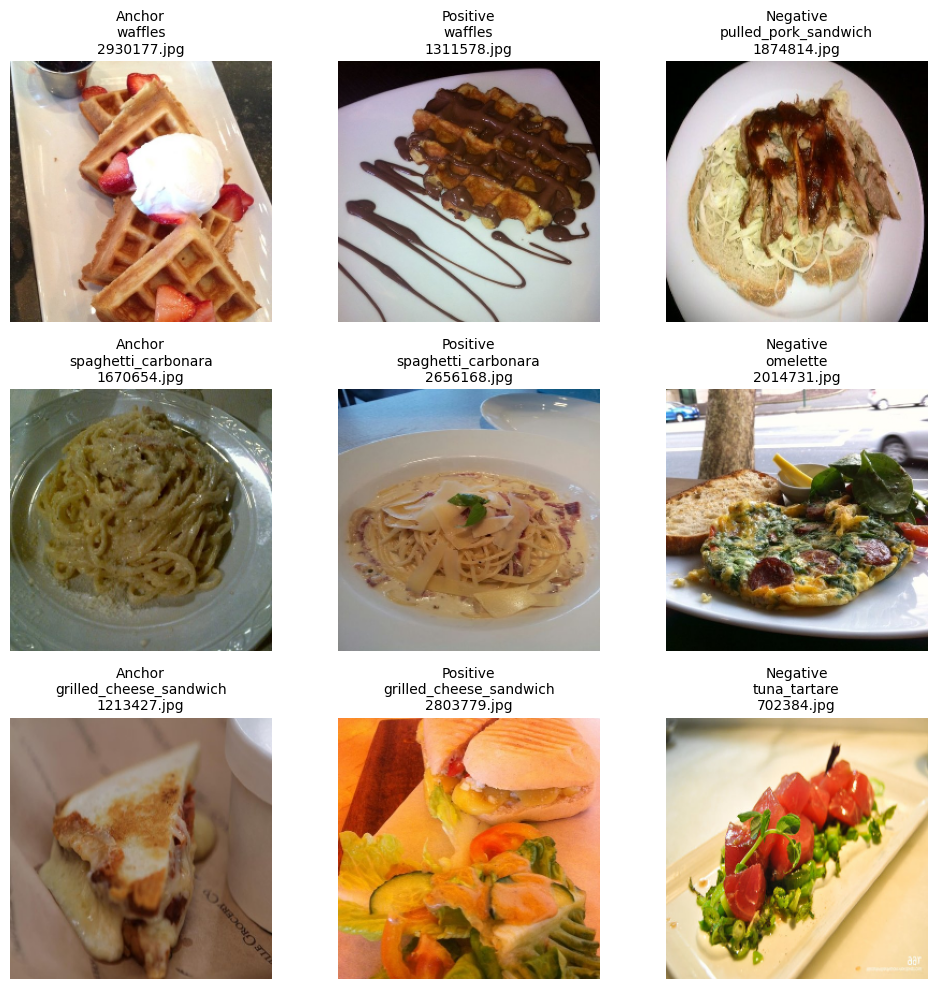

In [11]:
num_plots = 3
f, axes = plt.subplots(num_plots, 3, figsize=(10, 10))

# get the first batch
for x in get_batch("Train", trainTriplets, batch_size=num_plots):
    a_imgs, p_imgs, n_imgs = x

    for i in range(num_plots):
        anchor_meta, positive_meta, negative_meta = trainTriplets[i]

        # 2. Plot Anchor (Column 0)

        axes[i, 0].imshow(a_imgs[i].numpy().transpose((1, 2, 0)))
        axes[i, 0].set_title(f"Anchor\n{anchor_meta[0]}\n{anchor_meta[1]}", fontsize=10)
        axes[i, 0].axis("off")

        # 3. Plot Positive (Column 1)
        axes[i, 1].imshow(p_imgs[i].numpy().transpose((1, 2, 0)))
        axes[i, 1].set_title(
            f"Positive\n{positive_meta[0]}\n{positive_meta[1]}", fontsize=10
        )
        axes[i, 1].axis("off")

        # 4. Plot Negative (Column 2)
        axes[i, 2].imshow(n_imgs[i].numpy().transpose((1, 2, 0)))
        axes[i, 2].set_title(
            f"Negative\n{negative_meta[0]}\n{negative_meta[1]}", fontsize=10
        )
        axes[i, 2].axis("off")

    plt.tight_layout()
    break

In [12]:
class EmbeddingNet(nn.Module):
    """
    The base network for the Siamese architecture.
    """

    def __init__(self, embedding_dimension=128, conv_net="resnet50"):
        super(EmbeddingNet, self).__init__()

        mdls = {
            "vgg16": {
                "model": models.vgg16,
                "params": {
                    "weights": "IMAGENET1K_V1",
                },
            },
            "resnet50": {
                "model": models.resnet50,
                "params": {
                    "weights": "IMAGENET1K_V2",
                },
            },
            "mobilenetv3": {
                "model": models.mobilenet_v3_large,
                "params": {
                    "weights": "IMAGENET1K_V2",
                },
            },
            "googlenet": {
                "model": models.googlenet,
                "params": {
                    "weights": "IMAGENET1K_V1",
                },
            },
        }

        m = mdls[conv_net]
        self.model = m["model"](**m["params"])

        # different model have different names for lastest layers
        if "resnet" in conv_net or "googlenet" in conv_net:
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, embedding_dimension)
        elif "mobilenet" in conv_net:
            num_ftrs = self.model.classifier[3].in_features
            self.model.classifier[3] = nn.Linear(num_ftrs, embedding_dimension)
        elif "vgg" in conv_net:
            num_ftrs = self.model.classifier[6].in_features
            self.model.classifier[6] = nn.Linear(num_ftrs, embedding_dimension)

    def forward(self, x):
        # Pass input through the modified Model
        x = self.model(x)

        # Normalize the embeddings (optional but often beneficial)
        x = F.normalize(x, p=2, dim=1)
        return x

In [13]:
class TripletLoss(nn.Module):
    """
    Triplet Loss for training the Siamese network.
    It enforces that distance(Anchor, Positive) < distance(Anchor, Negative) - margin
    """

    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        """
        anchor, positive, negative: embedding vectors (N, embedding_dimension)
        """
        # Calculate Euclidean Distance Squared for stability (D(a, b)^2)
        # L2 norm (squared) is the sum of squared differences.

        # Distance between Anchor and Positive
        distance_positive = F.pairwise_distance(anchor, positive, p=2)
        # Distance between Anchor and Negative
        distance_negative = F.pairwise_distance(anchor, negative, p=2)

        # Triplet Loss calculation
        loss = F.relu(distance_positive - distance_negative + self.margin)

        # Return the average loss across the batch
        return loss.mean()

In [14]:
def training_step(
    model, optimizer, loss_fn, anchor_batch, positive_batch, negative_batch
):
    """
    Simulates a single training step.
    Note: In a real scenario, you'd load batches from a DataLoader.
    """
    model.train()  # Set model to training mode
    optimizer.zero_grad()

    # 1. Generate Embeddings for the triplet
    anchor_emb = model(anchor_batch.to(device))
    positive_emb = model(positive_batch.to(device))
    negative_emb = model(negative_batch.to(device))

    # 2. Compute the Triplet Loss
    loss = loss_fn(anchor_emb, positive_emb, negative_emb)

    # 3. Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item()

In [15]:
def validation_step(model, anchor_batch, positive_batch, negative_batch):
    model.eval()

    # 1. Generate Embeddings for the triplet
    anchor_emb = model(anchor_batch.to(device))
    positive_emb = model(positive_batch.to(device))
    negative_emb = model(negative_batch.to(device))

    p_distances = torch.cdist(anchor_emb, positive_emb, p = 2)
    n_distances = torch.cdist(anchor_emb, negative_emb, p = 2)

    d_ap = torch.diagonal(p_distances)
    d_an = torch.diagonal(n_distances)

    return torch.mean(d_an / d_ap + 1e-8)

In [16]:
# Define the embedding dimension (e.g., 128)

# Instantiate the Embedding Network
model = EmbeddingNet(embedding_dimension=EMBEDDING_DIM, conv_net=CONV_NET)

# Instantiate the Loss Function
triplet_loss_fn = TripletLoss(margin=MARGIN)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 181MB/s]


### 3. Instantiate and Use the Model

Cuda Available ?  True
Model instantiated on: cuda
Output embedding size: 64
ConvNet: googlenet
batch_number: 666, train_batches_count: 666
batch_number: 74, valid_batches_count: 74
Epoch 00|> Train loss: 1.1324, Validation ratio: 1.5722,Exec Time: 1058.2901821136475
--> New Best! 1.5722
Epoch 01|> Train loss: 0.7285, Validation ratio: 1.9172,Exec Time: 975.5574848651886
--> New Best! 1.9172
Epoch 02|> Train loss: 0.5402, Validation ratio: 2.1657,Exec Time: 974.1428797245026
--> New Best! 2.1657
Epoch 03|> Train loss: 0.4627, Validation ratio: 2.2483,Exec Time: 962.5351264476776
--> New Best! 2.2483
Epoch 04|> Train loss: 0.4200, Validation ratio: 2.2312,Exec Time: 968.9160239696503
Epoch 05|> Train loss: 0.3870, Validation ratio: 2.1543,Exec Time: 984.8513159751892
Epoch 06|> Train loss: 0.3607, Validation ratio: 2.1321,Exec Time: 966.5653862953186
Epoch 07|> Train loss: 0.3431, Validation ratio: 2.0892,Exec Time: 963.4985570907593
Epoch 08|> Train loss: 0.3299, Validation ratio: 2.10

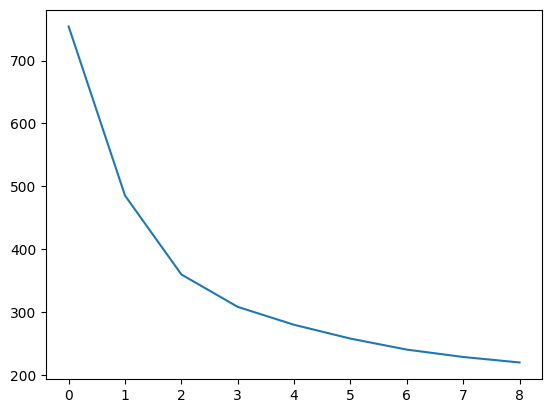

In [17]:
trainable_layer = None
if CONV_NET in ["resnet50", "googlenet"]:
    trainable_layer = {
        "layer": model.model.fc,
        "name": "fc"
    }  
elif CONV_NET in "mobilenetv3":
    trainable_layer = {
        "layer": model.model.classifier[3],
        "name": "classifier.3",
    }
elif CONV_NET in "vgg16":
    trainable_layer = {
        "layer": model.model.classifier[6],
        "name": "classifier.6",
    }

trainable_params = [
        {
            "params": trainable_layer["layer"].parameters(),
            "lr": 1e-4,
            "weight_decay": 1e-4,
        }, # New layer gets higher LR
        {
            "params": [p for name, p in model.named_parameters() if trainable_layer["name"] not in name],
            "lr": 1e-5,
        },  # Backbone gets low LR
]
# Define Optimizer (Example)
optimizer = torch.optim.Adam(trainable_params)


# Define a device
print("Cuda Available ? ", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model instantiated on: {device}")
print(f"Output embedding size: {EMBEDDING_DIM}")
print(f"ConvNet: {CONV_NET}")

# --- Example Training Step (Conceptual) ---

prinT = 1
loss_over_time = []
train_batches_count = int(np.ceil(len(trainTriplets) / BATCH_SIZE))
valid_batches_count = int(np.ceil(len(validationTriplets) / BATCH_SIZE))

patience = 5
counter = 0
best_val_loss = 0
best_model_state = None
for epoch in range(EPOCHS_COUNT):
    train_loss = 0
    batch_number = 0
    epoch_start = time.time()
    for x in get_batch(
        "Train", trainTriplets, batch_size=BATCH_SIZE, image_transforms=train_transforms
    ):
        batch_start = time.time()

        sample_loss = training_step(model, optimizer, triplet_loss_fn, x[0], x[1], x[2])
        train_loss += sample_loss
        batch_end = time.time()

        # print(f"Batch {batch_number:3d}|> Sample loss: {sample_loss:.4f}, Exec Time: {batch_end - batch_start}",end="\r",)
        # if batch_number % 10 == 0:
        #     print("")
        batch_number += 1

    if prinT:
        print(
            f"batch_number: {batch_number}, train_batches_count: {train_batches_count}"
        )
    loss_over_time.append(train_loss)

    model.eval()
    validation_loss = 0

    idx = 0
    with torch.no_grad():
        for x in get_batch("Validation", validationTriplets, batch_size=BATCH_SIZE):
            idx += 1
            validation_loss += validation_step(model, x[0], x[1], x[2])

    epoch_end = time.time()

    if prinT:
        print(f"batch_number: {idx}, valid_batches_count: {valid_batches_count}")
        prinT = 0

    train_loss /= train_batches_count
    validation_loss /= valid_batches_count
    print(
        f"Epoch {epoch:02d}|> Train loss: {train_loss:.4f}, Validation ratio: {validation_loss:.4f},Exec Time: {epoch_end - epoch_start}"
    )
    # --- EARLY STOPPING ---
    if validation_loss > best_val_loss:
        best_val_loss = validation_loss
        best_model_state = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), f"best_{CONV_NET}_{int(validation_loss * 1000)}.pth")
        print(f"--> New Best! {best_val_loss:.4f}")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("--> Early Stopping.")
            break

plt.cla()
plt.clf()
plt.plot(loss_over_time)
plt.savefig(f"{CONV_NET}_loss.png")